In [1]:
%config InlineBackend.figure_format = 'retina'

import os
from math import sqrt
from datetime import timedelta

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from astropy.coordinates import EarthLocation, SkyCoord, AltAz
from astropy import units as u
from astropy.time import Time
from astropy.io import fits

INFO:numexpr.utils:Note: detected 128 virtual cores but NumExpr set to maximum of 64, check "NUMEXPR_MAX_THREADS" environment variable.
INFO:numexpr.utils:Note: NumExpr detected 128 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


In [2]:
# Read in WAAS position data downloaded from the FAA web page

file_1130 = '/sdf/home/c/cwalter/notebooks/geosynchronous-satellites/waas_output_1130.csv'
file_1208 = '/sdf/home/c/cwalter/notebooks/geosynchronous-satellites/waas_output_1208.csv'

waas_1130 = pd.read_csv(file_1130, sep='\s+', header=None,
                        names=['jd','t0','ura','x','y','z','vx','vy','vz','ax','ay','az','f0','f1'])
waas_1208 = pd.read_csv(file_1208, sep='\s+', header=None,
                        names=['jd','t0','ura','x','y','z','vx','vy','vz','ax','ay','az','f0','f1'])

waas = pd.concat([waas_1130, waas_1208])

jd_time = Time(waas.jd, format='jd')
waas['date'] = pd.to_datetime(jd_time.utc.isot, utc=True)
waas.set_index('date', inplace=True)

waas = waas[['x','y','z']]
waas.head(5)

,x,y,z
date,,,
2024-11-30 00:00:47+00:00,-19145027.04,-37569500.08,1057.2
2024-11-30 00:05:03+00:00,-19145087.28,-37569471.28,1112.4
2024-11-30 00:09:19+00:00,-19145147.44,-37569441.28,1166.8
2024-11-30 00:13:35+00:00,-19145206.96,-37569410.32,1221.2
2024-11-30 00:17:51+00:00,-19145265.92,-37569378.56,1274.4


In [3]:
def get_interpolated_waas(df, tai_time, resample_period='30.0s'):

    stop_time = tai_time + 15.0*u.min
    start_time = tai_time - 15.0*u.min
    df_timewindow = df.loc[start_time.utc.iso:stop_time.utc.iso]
    
    df_resampled = df_timewindow.resample(resample_period).asfreq()
    combined = pd.concat([df_resampled, df_timewindow]).sort_index()
    combined = combined[~combined.index.duplicated(keep='first')] # Why is this only necessary now?!

    combined.interpolate(method='cubicspline', inplace=True)

    return df_timewindow, combined

def calculate_waas_position(interpolated, tai_time, time_offset=0):

    # Add a delta time to the header time if necessary.
    tai_time = tai_time + timedelta(seconds=time_offset)

    find_time = pd.to_datetime(tai_time.utc.isot, utc=True)
    found_index = interpolated.index.get_indexer([find_time], method='nearest')[0]

    found_time = interpolated.index[found_index]
    found_x = interpolated.iloc[found_index].x * u.m
    found_y =  interpolated.iloc[found_index].y * u.m
    found_z =  interpolated.iloc[found_index].z * u.m
    
    calc_time = tai_time.utc   # Note the .utc not really necessary. 
    ground = EarthLocation.of_site('Rubin Observatory')
    satelite = EarthLocation.from_geocentric(found_x, found_y, found_z)

    found_altaz = satelite.get_itrs(obstime=calc_time, location=ground).transform_to(AltAz(obstime=calc_time, location=ground))
    altaz_coordinate = SkyCoord(alt = found_altaz.alt, az = found_altaz.az, obstime=calc_time, location=ground, frame='altaz')

    fk5 = altaz_coordinate.transform_to('fk5')
    
    return found_time, fk5.ra.deg, fk5.dec.deg

#tai_time = Time("2024-11-30T05:55:41.111", scale='tai')
#df_timewindow, interpolated = get_interpolated_waas(waas, tai_time, '5s')

#interpolated.plot(x='x', y='y', kind='scatter',s=0.2)
#tai_time
#tai_time.utc

In [4]:
# Get hand scanned satellite data from processed fits files

satellite_data = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vRs-6gh1dIAjqTUdN-UOpQmaohx1U3ecO8vrb2EHUbBkoPeV14XWbtPW60-vy7cQt1Wcf1022tSo61J/pub?gid=1240073687&single=true&output=csv'
satellite_df = pd.read_csv(satellite_data)
satellite_df = satellite_df.set_index(['obsid', 'satellite'])

satellite_df = satellite_df.drop('Notes', axis=1)
satellite_df = satellite_df.dropna(how='all')
satellite_df

,,RA_Start,DEC_Start,Error_Start,RA_End,DEC_End,Error_End
obsid,satellite,,,,,,
CC_O_20241129_000237_R22_S21,EUTE 117W B,35.166472,4.626702,0.522,NaN,NaN,NaN
CC_O_20241129_000238_R22_S22,EUTE 117W B,35.232824,4.626801,0.347,NaN,NaN,NaN
CC_O_20241129_000239_R22_S22,EUTE 117W B,35.299805,4.626900,0.581,NaN,NaN,NaN
CC_O_20241129_000240_R22_S22,EUTE 117W B,35.365886,4.627031,0.506,NaN,NaN,NaN
CC_O_20241129_000246_R22_S11,EUTE 117W B,35.971827,4.627898,0.364,NaN,NaN,NaN
CC_O_20241129_000247_R22_S21,EUTE 117W B,36.038466,4.627908,0.514,NaN,NaN,NaN
CC_O_20241129_000249_R22_S22,EUTE 117W B,36.171805,4.628094,0.592,NaN,NaN,NaN
CC_O_20241129_000250_R22_S22,EUTE 117W B,36.238099,4.628133,0.679,NaN,NaN,NaN
CC_O_20241207_000549_R22_S21,EUTE 117W B,76.045773,4.696779,1.081,NaN,NaN,NaN


In [5]:
# Read metadata from processed FITS files and build a dataframe

records_list = []

for entry in sorted(os.scandir('/sdf/home/c/cwalter/processed-fits'), key=lambda x: x.name):
    with fits.open(entry.path) as hdu_list: 
       
        hdu = hdu_list[0]
        obs_id = hdu.header['OBSID']+'_'+ hdu.header['RAFTBAY'] +'_'+ hdu.header['CCDSLOT']
        tai_obs_date = Time(hdu.header['DATE-BEG'], scale='tai')

        # Get WAAS Info
        df_timewindow, interpolated = get_interpolated_waas(waas, tai_obs_date, '.01s')
        waas_tuple = calculate_waas_position(interpolated, tai_obs_date)
        records_list.append([obs_id] + [tai_obs_date] + [*waas_tuple])

df = pd.DataFrame(records_list, columns=['obsid', 'tai_time', 'waas_time', 'waas_RA', 'waas_DEC'])
df = df.merge(satellite_df, how='inner', on=['obsid'])

#df[['obsid', 'tai_time', 'waas_time', 'waas_RA', 'waas_DEC','RA_Start', 'DEC_Start']]

In [6]:
EUTEL_WAAS = df.assign(delta_ra = lambda x: (x.RA_Start - x.waas_RA)*3600) \
       .assign(delta_dec = lambda x: (x.DEC_Start - x.waas_DEC)*3600) \
       .assign(abs_delta_ra = lambda x: abs(x.delta_ra)) \
       .assign(abs_delta_dec = lambda x: abs(x.delta_dec)) 

#EUTEL_WAAS[['tai_time', 'delta_ra', 'Error_Start']]

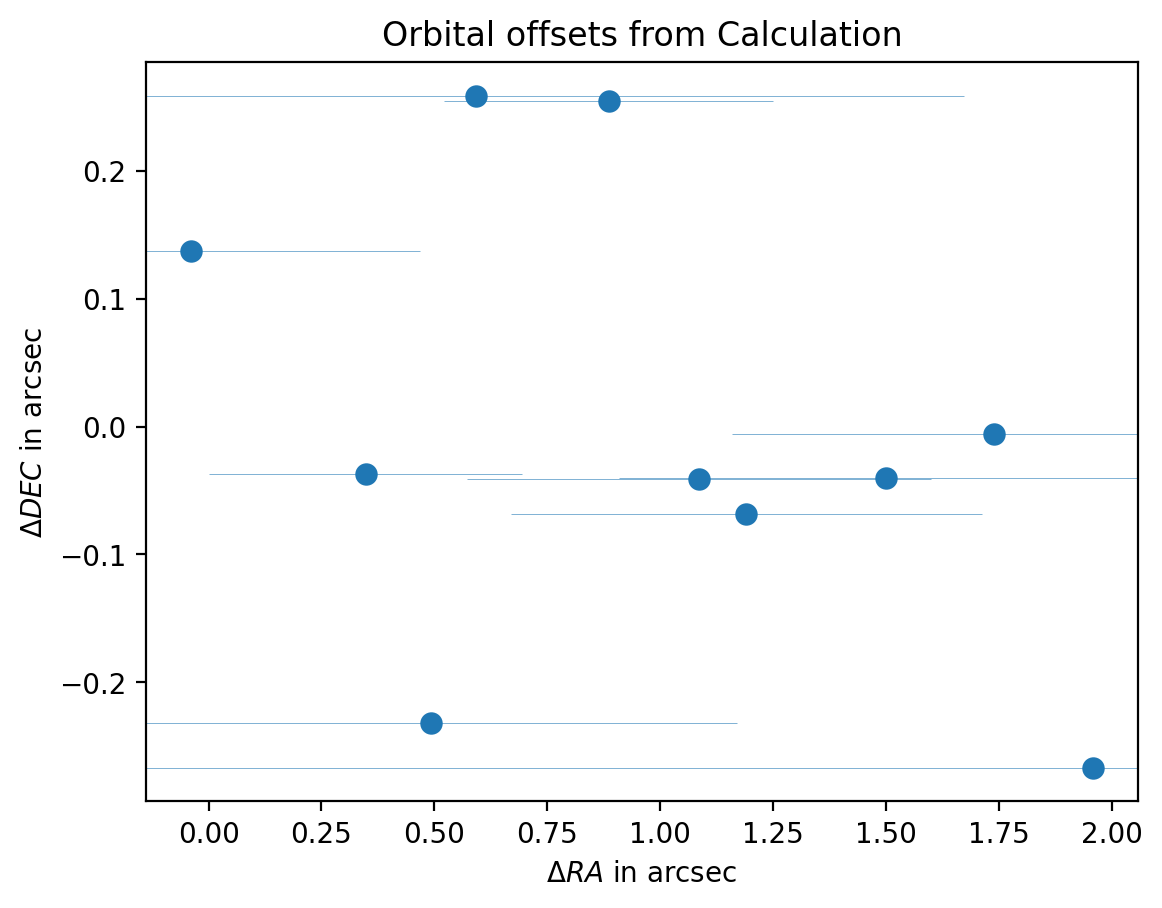

In [7]:
#EUTEL_WAAS.plot.scatter('delta_ra', 'delta_dec', marker='o', s=50)
plt.errorbar(EUTEL_WAAS.delta_ra, EUTEL_WAAS.delta_dec, fmt='o', ms=7.07, xerr=EUTEL_WAAS.Error_Start, elinewidth=0.2)

plt.title('Orbital offsets from Calculation')
plt.xlabel('$\Delta RA$ in arcsec')
plt.ylabel('$\Delta DEC$ in arcsec')
plt.xlim(-0.13851634332084473, 2.0573575799313915);

STD of delta_RA is 0.641


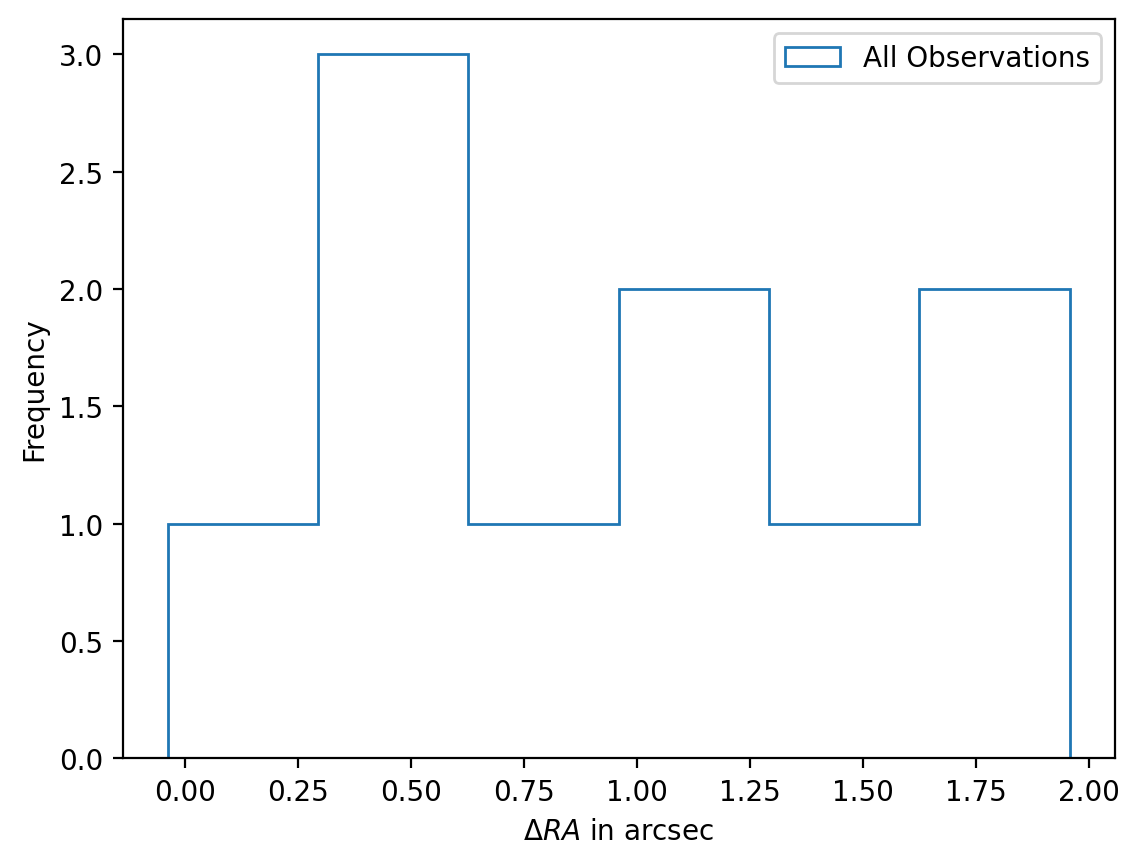

In [8]:
# Look at the distribution of delta_ras

EUTEL_WAAS.delta_ra.plot.hist(bins=6, histtype='step', label='All Observations')

plt.xlabel('$\Delta RA$ in arcsec')
plt.legend(fontsize=10);

print(f'STD of delta_RA is {EUTEL_WAAS.delta_ra.std():4.3f}')

In [9]:
# Calculate the mean errors and the start error positions I measured
print(f'EUTEL: \t {EUTEL_WAAS.delta_ra.mean():4.2f} (+-{EUTEL_WAAS.delta_ra.std():4.2f}) +- {EUTEL_WAAS.Error_Start.mean():4.2f}')

EUTEL: 	 0.98 (+-0.64) +- 0.77


In [10]:
# Calculate the average error in RA but weight the entires by my measured errors 
# on the start positions.
#
# See https://stackoverflow.com/questions/2413522/weighted-standard-deviation-in-numpy

values = EUTEL_WAAS.delta_ra
weights = EUTEL_WAAS.Error_Start
weighted_avg = np.average(values, weights=weights)
weighted_std = sqrt(np.average((values-weighted_avg)**2, weights=weights))

print('Rough guess on precision:')
print(f'Weighted averages: {weighted_avg:4.2f}" +- {weighted_std:4.2f}"')
print(f'In milliseconds: {weighted_avg/15*1000:4.2f} ms +- {weighted_std/15*1000:4.2f} ms')
print(f'In milliseconds scaled by sqrt(10): {weighted_avg/15*1000:4.2f} ms +- {weighted_std/15*1000/sqrt(10):4.2f} ms')

Rough guess on precision:
Weighted averages: 1.22" +- 0.67"
In milliseconds: 81.65 ms +- 44.80 ms
In milliseconds scaled by sqrt(10): 81.65 ms +- 14.17 ms


In [11]:
# Functions for fit
# Needs WAAS external global data frame defined:

def calculate_position_df(data_frame, tai_vector, time_offset):  
    
    sat_ra = np.zeros(len(tai_vector))
    sat_dec = np.zeros(len(tai_vector))
    
    # For each satellite and TLE find the position
    data_frame = data_frame.reset_index()  # make sure indexes pair with number of rows
    for i, row in data_frame.iterrows():
        
        # Get WAAS Info
        df_timewindow, interpolated = get_interpolated_waas(waas, tai_vector[i], '.01s')
        waas_tuple = calculate_waas_position(interpolated, tai_vector[i], time_offset)
        sat_ra[i], sat_dec[i] = waas_tuple[1], waas_tuple[2]

    return sat_ra

def pdf(modified_julian_dates, time_offset=0):
    # Turn the MJD float back into a TAI Time item (seems to be good to 1e-12 seconds)
    tai_vector = [Time(item, format='mjd', scale='tai') for item in modified_julian_dates]
    sat_ra =  calculate_position_df(df, tai_vector, time_offset)
    
    return sat_ra

In [12]:
# Test PDF function
# The PDF function requires a float.  So turn the TAI time into MJD
# mjds = [item.mjd for item in df.tai_time]
# df['calc_ra'] = pdf(mjds, time_offset = 0.0)
# df[['obsid','waas_RA', 'waas_DEC','RA_Start', 'DEC_Start', 'calc_ra']]

In [13]:
from iminuit import Minuit
from iminuit.cost import LeastSquares, NormalConstraint

def viz(args):
    plt.hist((measured_ra - pdf(times, 0))*3600, bins=6, histtype='step', label='System Time')
    plt.hist((measured_ra - pdf(times, *args))*3600, bins=6, histtype='step', label='Fitted Offset')

    plt.legend(loc="upper right")
    plt.xlabel('$\Delta RA$ in arcsec')

times = [item.mjd for item in df.tai_time]
measured_ra = df.RA_Start.values
error_ra = df.Error_Start.values/3600

least_squares = LeastSquares(times, measured_ra, error_ra, pdf) 
least_squares.visualize = viz
least_squares.verbose = 0

m = Minuit(least_squares, time_offset=0.0)  # starting values for offset
m.fixed['time_offset'] = False

m.simplex()
m.migrad()  # finds minimum of least_squares function
m.hesse()  # accurately computes uncertainties

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 9.829 (χ²/ndof = 1.1)      │              Nfcn = 35               │
│ EDM = 1.55e-06 (Goal: 0.0002)    │            time = 6.3 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬─────────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name        │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼─────────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ time_offset │   0.054   │   0.011   │            │            │         │         │       │
└───┴─────────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌─────────────┬─────────────┐
│             │ time_offset │
├─────────────┼─────────────┤
│ time_offset │    0.000122 │
└─────────────┴─────────────┘

In [14]:
# Manual Check of fit quality

mjds = [item.mjd for item in df.tai_time]
new_error = df.Error_Start.values/3600

chi2 = (((measured_ra - pdf(mjds, time_offset = m.values[0]))/new_error)**2).sum()
print(f'Chi2 = {chi2:4.2f}')

pulls = least_squares.pulls(m.values)
print(f'Pulls mean = {pulls.mean():4.2f} std = {pulls.std():4.2f}')

Chi2 = 9.83
Pulls mean = 0.11 std = 0.99


In [15]:
print(f'{m.values[0]*1000:5.2f} +- {m.errors[0]*1000:4.2f} milliseconds')
print(f'{m.values[0]*1000*.075:5.2f} +- {m.errors[0]*1000*.075:4.2f} pixels')
print(f'FCN: {m.fcn(m.values):4.4f}')
print()
print(f'{m.values[0]/m.errors[0]:2.2} sigma from zero')

m.params

53.63 +- 11.04 milliseconds
 4.02 +- 0.83 pixels
FCN: 9.8286

4.9 sigma from zero


,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed
0,time_offset,0.054,0.011,,,,,


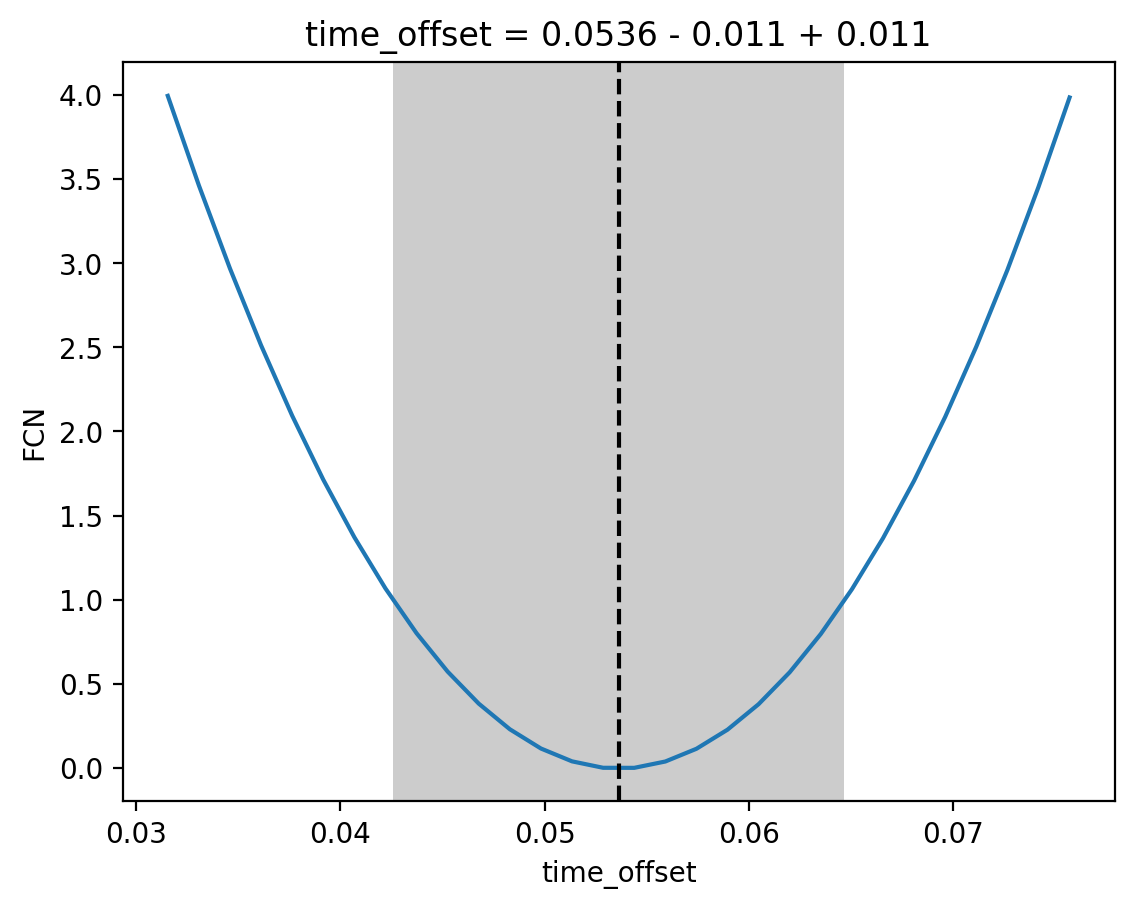

In [16]:
m.draw_mnprofile("time_offset");